# Belgium

In [124]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

%config InlineBackend.figure_format = 'retina'
pd.options.mode.chained_assignment = None

## Fetch results

In [2]:
# So few provinces so we just manually write them down
# Cantons and municipalities seem trickier
data = [
    {
        'id': 'EUP21004',
        'nsi': 'BRU',
        'name': 'Constituency of Brussels-Capital',
        'turnout': 83.53
    },
    {
        'id': 'EUP11002',
        'nsi': 'VAN',
        'name': 'Antwerp',
        'turnout': 90.34
    },
    {
        'id': 'EUP44021',
        'nsi': 'VOV',
        'name': 'East-Flanders',
        'turnout': 92.01
    },
    {
        'id': 'EUP24062',
        'nsi': 'VBR',
        'name': 'Flemish Brabant',
        'turnout': 90.9
    },
    {
        'id': 'EUP53053',
        'nsi': 'WHT',
        'name': 'Hainaut',
        'turnout': 87.66
    },
    {
        'id': 'EUP62063',
        'nsi': 'WLG',
        'name': 'Liège',
        'turnout': 86.58
    },
    {
        'id': 'EUP71022',
        'nsi': 'VLI',
        'name': 'Limburg',
        'turnout': 92.83
    },
    {
        'id': 'EUP81001',
        'nsi': 'WLX',
        'name': 'Luxembourg',
        'turnout': 90.59
    },
    {
        'id': 'EUP92094',
        'nsi': 'WNA',
        'name': 'Namur',
        'turnout': 88.42
    },
    {
        'id': 'EUP25072',
        'nsi': 'WBR',
        'name': 'Walloon Brabant',
        'turnout': 89.42
    },
    {
        'id': 'EUP31005',
        'nsi': 'VWV',
        'name': 'West-Flanders',
        'turnout': 91.49
    }
]

In [116]:
def get_links():
    base_url = 'http://polling2014.belgium.be/en/eur/search/search_com_{}.html'
    links = []
    for letter in ['a', 'e', 'l', 'r']:
        url = base_url.format(letter)
        r = requests.get(url)
        html = BeautifulSoup(r.text)
        table = html.select('table')[33]
        rows = table.select('tr[valign="middle"]')
        links.extend([x.select_one('a').attrs['href'] for x in rows])
    return set(links)

In [168]:
def get_data(links):
    base_url = 'http://polling2014.belgium.be/en/eur'
    data = []
    for link in links:
        url = f'{base_url}/{link.split("/", 1)[1]}'
        r = requests.get(url)
        html = BeautifulSoup(r.text)
        table = html.select('table')[-4]
        frame = pd.read_html(str(table), thousands='.')[0]
        crumbs = html.select_one('table.crumbselected#noprint')
        crumbs = crumbs.select('tr')[1].select('td')[2]
        crumbitems = [x.text for x in crumbs.select('a')]
        crumbitems.append(crumbs.select('strong')[1].text)
        data.append({
            'id': url.split('EUK')[1].split('.')[0],
            'crumbs': crumbitems,
            'total': frame.loc[1, 2],
            'voters': frame.loc[4, 2],
            'turnout': frame.loc[4, 4]
        })
    return data

In [169]:
links = get_links()

In [170]:
%%time
data = get_data(links)

CPU times: user 17.8 s, sys: 321 ms, total: 18.1 s
Wall time: 1min 3s


In [171]:
df = pd.DataFrame(data)

In [172]:
df['canton'] = df.crumbs.apply(lambda x: x[-1])

In [173]:
df.canton = df.canton.str.split(' of ', expand=True)[1]

In [174]:
df.canton = (df.canton
    .replace('Sankt Vith', 'Sankt-Vith')
    .replace('Antwerp', 'Antwerpen')
    .replace('Ixelles', 'Ixelles | Elsene')
    .replace('Brussels', 'Bruxelles | Brussel')
    #.replace('Rhode-Saint-Genèse/sint-Genesius-Rode': '')
    .replace('Eeklo', 'Eekloo')
    .replace('Etalle', 'Étalle')
    .replace('Saint-Josse-Ten-Noode', 'Saint-Josse | Sint-Joost')
    .replace('Schaerbeek', 'Schaerbeek | Schaarbeek')
    .replace('Uccle', 'Uccle | Ukkel')
    .replace('Molenbeek-Saint-Jean', 'Molenbeek-Saint-Jean | Sint-Jans-Molenbeek')
    .replace('Ghent', 'Gent')
    .replace('Vielsalm', 'Vielsam')
    .replace('Neufchâteau', 'Neufchateau')
    .replace('Lichtervelde', 'Lichterveld')
    .replace('Saint-Gilles', 'Saint-Gilles | Sint-Gillis')
    .replace('Sainte-Ode', 'Saint-Ode')
    .replace("Fontaine-l'Evêque", "Fontaine-l'Évêque"))

In [180]:
df.total = df.total.astype(int)
df.voters = df.voters.astype(int)

In [181]:
df.turnout = df.turnout.str.replace('%', '').str.replace(',', '.').astype(float)

In [183]:
df.to_csv('../../data/raw/bel.csv', index=False)

## Merge

In [184]:
geo = gpd.read_file('../../data/shapefiles/bel/cantons1_L08.shp', encoding='utf8')
geo = geo.to_crs(epsg=4326)

In [186]:
geo = geo.merge(df, left_on='Name', right_on='canton', how='left')

In [188]:
geo = geo[['Name', 'geometry', 'turnout']]
geo = geo.rename(columns={'Name': 'name'})

## Export

In [189]:
geo['country'] = 'bel'

In [192]:
geo.to_file('../../data/processed/bel', encoding='utf8')

## Visualize

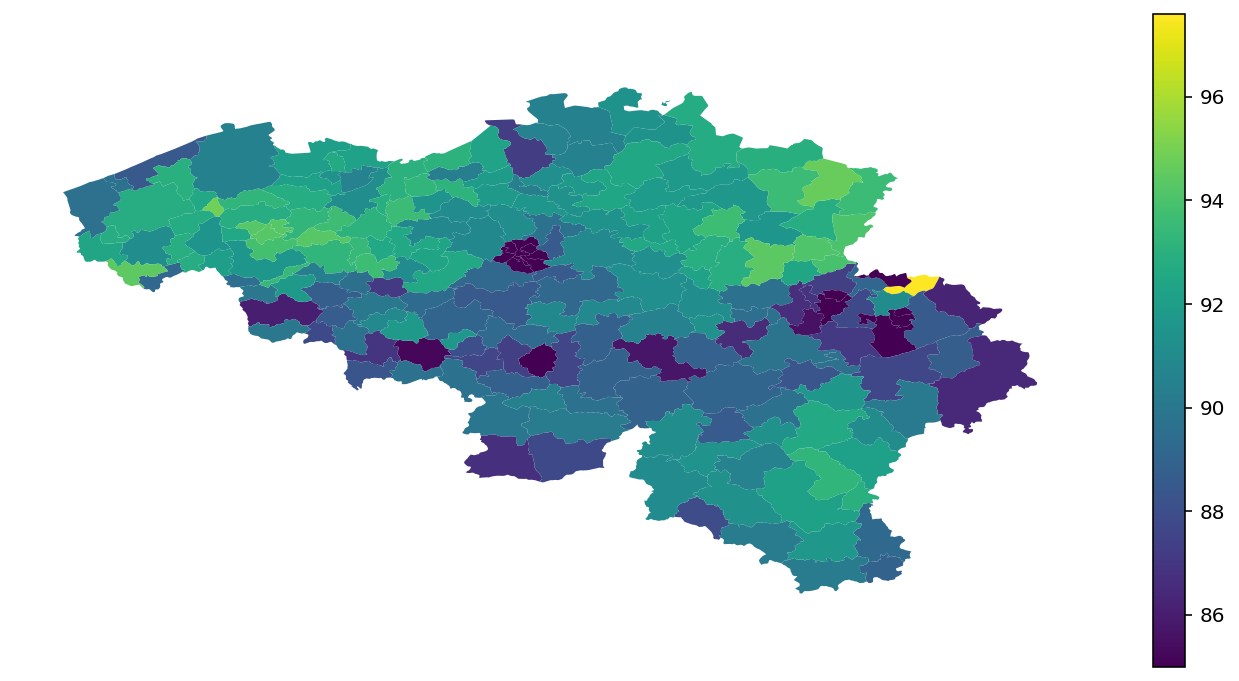

In [198]:
ax = geo.plot(figsize=(12, 6), column='turnout', vmin=85, legend=True);
fig = ax.get_figure()
fig.set_facecolor('#ffffff')
ax.set_axis_off()
fig.savefig('../../reports/bel_choropleth.png')